## The Impact of Labour's 2024 Autumn Budget on UK Constituencies

On 30th October, the Chancellor Rachel Reeves will announce proposals for the UK's tax and spending decisions over the next five years in the first Autumn Budget of the new Labour government. The reforms include:

1. Tax avoidance measures
2. Private school VAT
3. Employer NICs (learn more)
4. Capital Gains Tax reforms

### Data and Methodology

Using PolicyEngine UK's microsimulation model, we simulate the baseline household incomes and population counts for 2024, and project these forward to 2029 incorporating the proposed reforms.
To account for constituency boundary changes, we apply a mapping matrix to transform data from 2010 constituency boundaries to the new 2024 boundaries. This ensures our analysis reflects the current political geography of the UK. For each constituency, we calculate the relative change in per capita income between 2024 and 2029. 

First, let's import the required libraries and set up our microsimulation:

In [1]:
from policyengine_uk import Microsimulation
from policyengine_core.reforms import Reform
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Define the Reform Package
We encode Labour's proposed reforms for 2024-2029:

In [2]:
reform = Reform.from_dict({
  "gov.contrib.labour.private_school_vat": {
    "2025-01-01.2025-12-31": 0.2
  },
  "gov.contrib.policyengine.budget.high_income_incident_tax_change": {
    "2024-01-01.2100-12-31": 5.9
  },
  "gov.contrib.policyengine.employer_ni.employee_incidence": {
    "2025-01-01.2025-12-31": 0.4,
    "2026-01-01.2026-12-31": 0.5,
    "2027-01-01.2027-12-31": 0.6,
    "2028-01-01.2030-12-31": 0.7
  },
  "gov.contrib.policyengine.employer_ni.exempt_employer_pension_contributions": {
    "2024-01-01.2100-12-31": False
  },
  "gov.hmrc.cgt.additional_rate": {
    "2025-01-01.2025-12-31": 0.24
  },
  "gov.hmrc.cgt.higher_rate": {
    "2025-01-01.2025-12-31": 0.24
  }
}, country_id="uk")


### Calculate Baseline and Reformed Scenarios

In [3]:
baseline = Microsimulation()
reformed = Microsimulation(reform=reform)
baseline_income = baseline.calculate("real_household_net_income", period=2024)
reformed_income = reformed.calculate("real_household_net_income", period=2029)
baseline_people = baseline.calculate("people", map_to = "household", period=2024)
reformed_people = baseline.calculate("people", map_to = "household", period=2029)

### Data Processing Function
This function processes our microsimulation results to calculate constituency-level changes:

In [4]:
def get_income_difference_data():
    constituencies = pd.read_csv("../policyengine_uk_local_areas/constituencies_2024.csv")
    hex_locations = pd.read_csv("../policyengine_uk_local_areas/hex_map/hex_map_2024.csv")
    
    with h5py.File("../constituencies/weights.h5", "r") as f:
        weights = f["weight"][:]
    
    mapping_matrix = pd.read_csv("../mapping_2010_to_2024/mapping_matrix.csv")
    mapping_matrix = mapping_matrix.set_index(mapping_matrix.columns[0])
    mapping_matrix = mapping_matrix.div(mapping_matrix.sum(), axis=1)
    
    weights_2024 = mapping_matrix.T.dot(weights)
    
    # Calculate income and population for each constituency
    income_2024 = np.dot(weights_2024, baseline_income.values)
    income_2029 = np.dot(weights_2024, reformed_income.values)
    population_2024 = np.dot(weights_2024, baseline_people.values)
    population_2029 = np.dot(weights_2024, reformed_people.values)
    
    # Calculate per capita income for each year
    per_capita_2024 = income_2024 / population_2024
    per_capita_2029 = income_2029 / population_2029
    
    # Calculate relative difference in per capita income
    income_difference = (per_capita_2029 - per_capita_2024) / per_capita_2024 * 100
    
    df = pd.DataFrame({
        'code': mapping_matrix.columns,
        'income_difference': income_difference
    })
    df = df.merge(constituencies[['code', 'name']], on='code', how='left')
    merged_df = pd.merge(df, hex_locations, on='code', how='inner')

    merged_df.x = merged_df.x + (merged_df.y % 2 == 0) * 0.5
    
    return merged_df

### Visualization
Create our hexagonal map visualization:

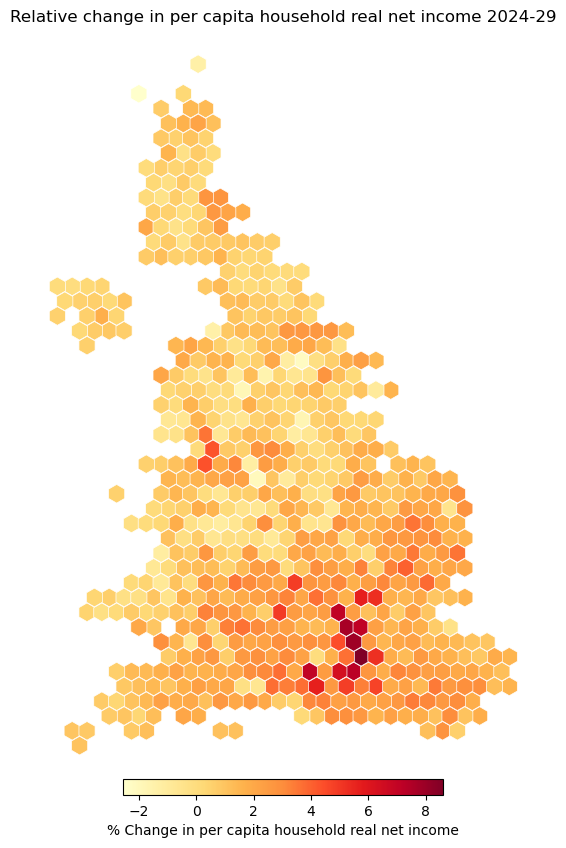

In [5]:
# Get the data
data = get_income_difference_data()

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(
    data['x'], 
    data['y'], 
    c=data['income_difference'],  
    cmap='YlOrRd',
    alpha=1,
    marker='h',
    s=180,
    linewidths=0.5,
    edgecolors='white'
)

ax.set_aspect('equal')
ax.axis('off')
ax.set_facecolor('#f0f0f0')
ax.set_title('Relative change in per capita household real net income 2024-29')

# Add colorbar at the bottom
cax = fig.add_axes([0.3, 0, 0.4, 0.02])
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='% Change in per capita household real net income')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()